# Objective

#### In this notebook we analyze the clusters obtained from the CDR (Call Detail Record) dataset. We use temporal usage profiles (weekday vs weekend) and spatial distribution over Milan to interpret what each cluster represents. The goal is to assign meaningful storytelling names to clusters, beyond technical labels, so they can be communicated to business and policy stakeholders.

In [9]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

sns.set_theme(style="whitegrid", context="talk")

ROOT = Path.cwd().parent
ART  = ROOT / "artifacts"
FIG  = ART / "figures"

# Load artifacts produced by Notebook 2
k_eval          = pd.read_csv(ART / "k_evaluation.csv")
centers_long    = pd.read_csv(ART / "cluster_centers_long.csv")
scales_df       = pd.read_csv(ART / "cluster_scales.csv")
clusters_by_cell= pd.read_csv(ART / "clusters_by_cell.csv")
hourly_by_cell  = pd.read_csv(ART / "hourly_by_cell_with_cluster.csv")
city_hourly     = pd.read_csv(ART / "hourly_city_totals.csv")
centroids = pd.read_csv(ROOT / "milan_cell_centroids.csv")


# Quick peeks
k_eval.head(2), centers_long.head(2), scales_df.head(2), clusters_by_cell.head(2), hourly_by_cell.head(2), city_hourly.head(2)


(   k  silhouette  davies_bouldin
 0  3    0.531800        0.574107
 1  4    0.522617        0.544575,
    cluster    phase  hour     share
 0        0  Weekday     0  0.033909
 1        0  Weekend     0  0.039321,
    cluster  log_avg_volume
 0        0        6.859853
 1        1        3.766836,
    square_id  cluster       lon        lat
 0          1        1  9.012991  45.357743
 1          2        1  9.015991  45.357743,
    square_id  hour  avg_internet_bytes  cluster       lon        lat
 0          1     0             53.4129        1  9.012991  45.357743
 1          1     1             44.9797        1  9.012991  45.357743,
    hour  avg_internet_bytes
 0     0          335.555021
 1     1          279.479043)

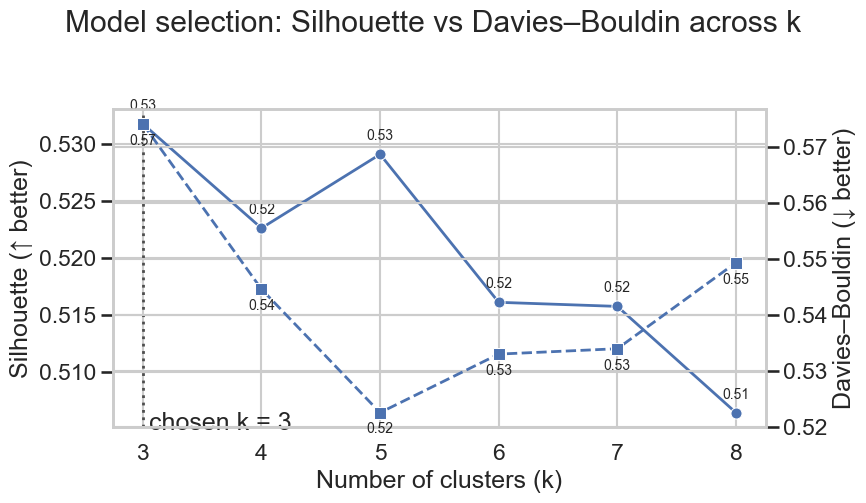

Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\figures\k_selection_from_artifacts.png | chosen k: 3


In [11]:
# K-selection figure

fig, ax1 = plt.subplots(figsize=(9,5))

# Silhouette (higher is better)
sns.lineplot(
    data=k_df, x="k", y="silhouette",
    marker="o", ax=ax1, linewidth=2, markersize=8
)
ax1.set_ylabel("Silhouette (‚Üë better)")
ax1.set_xlabel("Number of clusters (k)")

# Davies‚ÄìBouldin (lower is better) on a twin axis
ax2 = ax1.twinx()
sns.lineplot(
    data=k_df, x="k", y="davies_bouldin",
    marker="s", ax=ax2, linewidth=2, markersize=8, linestyle="--"
)
ax2.set_ylabel("Davies‚ÄìBouldin (‚Üì better)")

# Highlight chosen k
ax1.axvline(best_k, color="0.3", linestyle=":", linewidth=2)
ax1.text(best_k+0.05, ax1.get_ylim()[1]*0.95, f"chosen k = {best_k}", va="top")

# Annotate points with values
for _, r in k_df.iterrows():
    ax1.annotate(f"{r['silhouette']:.2f}", (r["k"], r["silhouette"]),
                 textcoords="offset points", xytext=(0,10), ha="center", fontsize=10)
    ax2.annotate(f"{r['davies_bouldin']:.2f}", (r["k"], r["davies_bouldin"]),
                 textcoords="offset points", xytext=(0,-15), ha="center", fontsize=10)

fig.suptitle("Model selection: Silhouette vs Davies‚ÄìBouldin across k", y=1.02)
fig.tight_layout()
out = FIG / "k_selection_from_artifacts.png"
fig.savefig(out, dpi=200); plt.show()
print("Saved:", out, "| chosen k:", best_k)


### üîé Cluster number selection

We evaluated **k = 3‚Äì8** clusters using two internal metrics:

- **Silhouette score (‚Üë better):** peaked at **k = 3** (~0.53), indicating the best separation between clusters.
- **Davies‚ÄìBouldin index (‚Üì better):** also lowest at **k = 3** (~0.53), showing compact and well-separated groups.

üëâ Both metrics agree that **k = 3** provides the most meaningful structure.  
This means Milan‚Äôs cell-level activity can be explained by **three dominant behavioral patterns**.


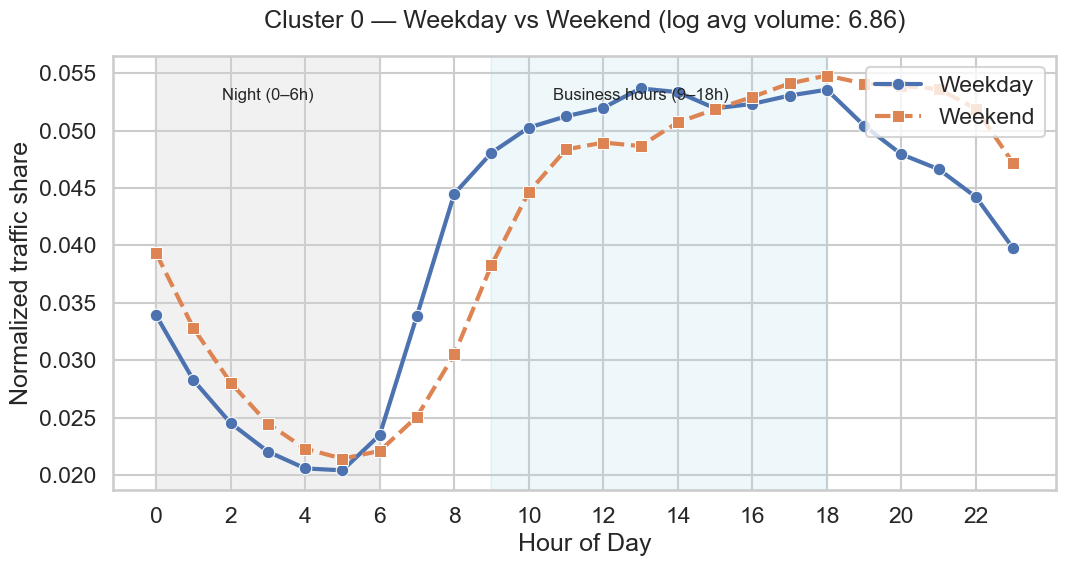

Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\figures\cluster_0_profile_from_artifacts.png


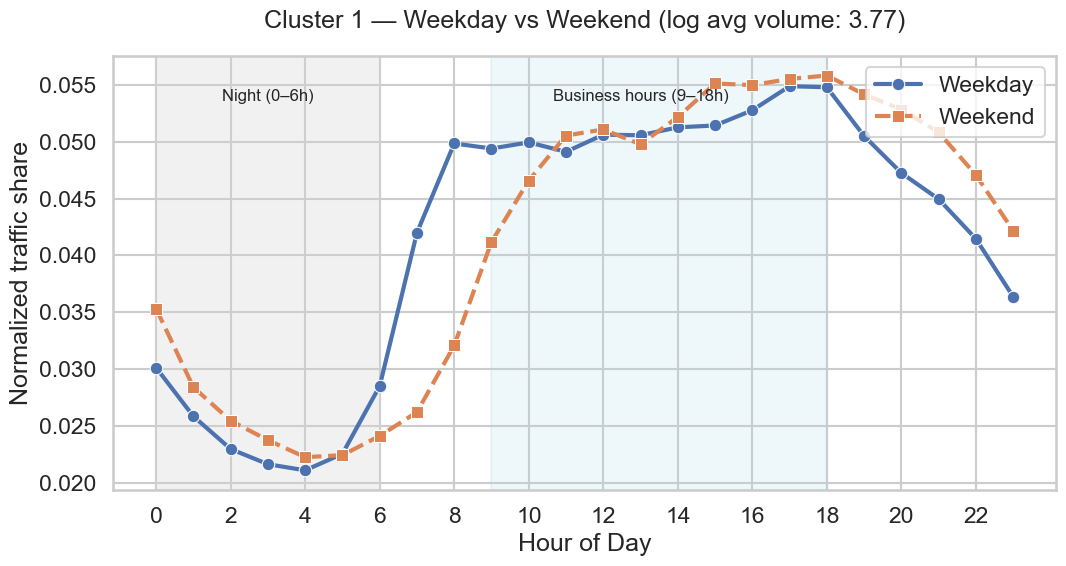

Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\figures\cluster_1_profile_from_artifacts.png


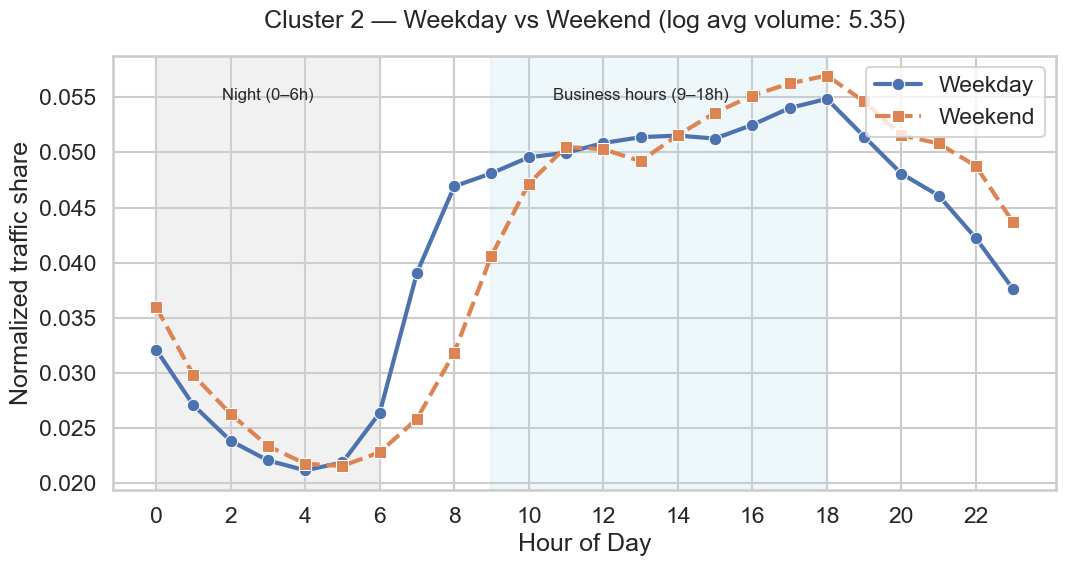

Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\figures\cluster_2_profile_from_artifacts.png


In [13]:
def plot_cluster_profile_from_artifacts(centers_long, scales_df, c, out_dir: Path):
    sub = centers_long[centers_long["cluster"]==c]
    scl = float(scales_df.loc[scales_df["cluster"]==c, "log_avg_volume"].values[0])

    fig, ax = plt.subplots(figsize=(11,6))
    # Shaded bands
    ax.axvspan(0, 6,  color="lightgrey", alpha=0.3)
    ax.axvspan(9, 18, color="lightblue",  alpha=0.2)

    sns.lineplot(data=sub[sub["phase"]=="Weekday"], x="hour", y="share",
                 linewidth=3, marker="o", label="Weekday", ax=ax)
    sns.lineplot(data=sub[sub["phase"]=="Weekend"], x="hour", y="share",
                 linewidth=3, marker="s", linestyle="--", label="Weekend", ax=ax)

    ax.set_title(f"Cluster {c} ‚Äî Weekday vs Weekend (log avg volume: {scl:.2f})", fontsize=18, pad=20)
    ax.set_xlabel("Hour of Day"); ax.set_ylabel("Normalized traffic share")
    ax.set_xticks(range(0,24,2)); ax.legend(loc="upper right")
    ax.text(3,  ax.get_ylim()[1]*0.95,  "Night (0‚Äì6h)", ha="center", va="top", fontsize=12)
    ax.text(13, ax.get_ylim()[1]*0.95, "Business hours (9‚Äì18h)", ha="center", va="top", fontsize=12)

    fig.tight_layout()
    out = out_dir / f"cluster_{c}_profile_from_artifacts.png"
    fig.savefig(out, dpi=200); plt.show()
    print("Saved:", out)

for c in sorted(centers_long["cluster"].unique()):
    plot_cluster_profile_from_artifacts(centers_long, scales_df, int(c), FIG)


### üîé Cluster 0 
- Highest average volume (~6.9).
- Strong **weekday daytime peak (9‚Äì18h)**, low night activity.
- Weekend traffic also high but more evenly spread.

---

### üîé Cluster 1 
- Lowest average volume (~3.8).
- **Evening and weekend activity** dominate relative to daytime.
- Sustained use late into the night compared to Cluster 0.
---

### üîé Cluster 2 
- Medium-high average volume (~5.3).
- Balanced traffic across **weekday and weekend**, including evenings.
- Profile shows less sharp weekday peaks and higher weekend evenings.


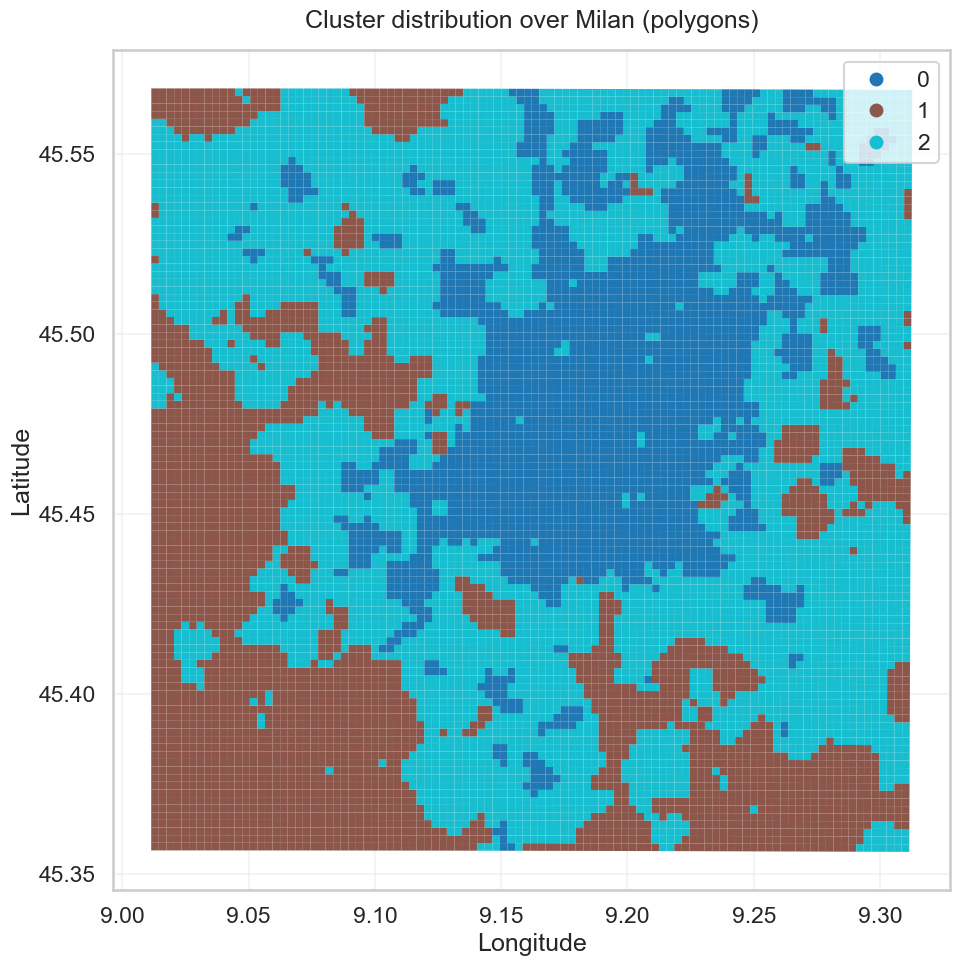

Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\figures\cluster_map_from_csv_geojson.png


In [20]:
# Plot polygons colored by cluster
grid_path = ROOT / "data" / "milano-grid.geojson"
grid = gpd.read_file(grid_path)
grid["square_id"] = grid["cellId"].astype("int32")

grid = grid.merge(clusters_by_cell[["square_id","cluster"]], on="square_id", how="left")

fig, ax = plt.subplots(figsize=(10,10))
grid.plot(column="cluster", categorical=True, legend=True, linewidth=0, ax=ax)

ax.set_title("Cluster distribution over Milan (polygons)", pad=16, fontsize=18)
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude"); ax.grid(alpha=0.2)

fig.tight_layout()
out = FIG / "cluster_map_from_csv_geojson.png"
fig.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

### üåç Spatial‚Äìtemporal interpretation of clusters

The spatial map confirms the temporal profiles:

- **Cluster 0 (üè¢ Business / Commercial Hubs)** ‚Üí concentrated in central Milan, matching the weekday daytime peak (9‚Äì18h).  
- **Cluster 1 (üè† Residential Evening Areas)** ‚Üí spread across the suburban belt, aligning with evening/weekend activity.  
- **Cluster 2 (üõçÔ∏è Leisure & Mixed-use Districts)** ‚Üí surrounds the city center in semi-central corridors, consistent with balanced usage across weekdays and weekends.  

üëâ Together, the three clusters reveal Milan‚Äôs **urban digital rhythm**: daytime activity downtown, residential usage in the periphery, and mixed-use/leisure engagement in the transition zones.


C:\Users\tempadmin.DESKTOP-C50JUBO\AppData\Local\Temp\ipykernel_10136\3695696199.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cells_per, x="cluster", y="cells", ax=axes[0], palette="Set2")
C:\Users\tempadmin.DESKTOP-C50JUBO\AppData\Local\Temp\ipykernel_10136\3695696199.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=contrib, x="cluster", y="total_KB", ax=axes[1], palette="Set2")


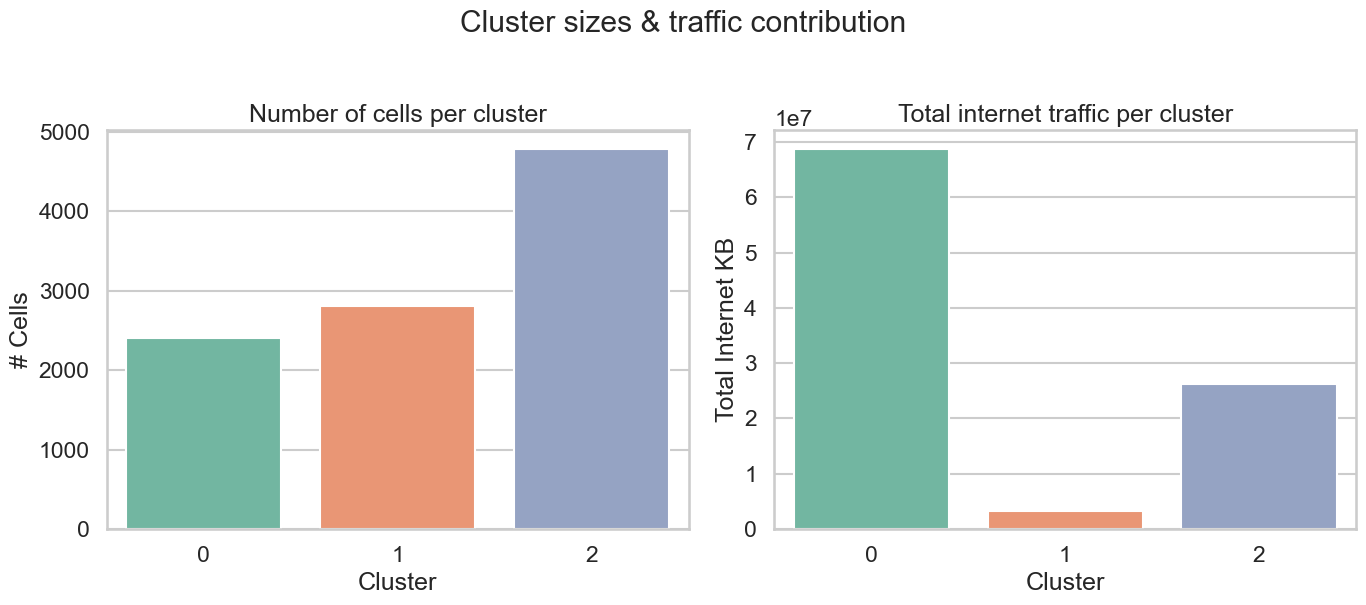

Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\figures\cluster_sizes_contribution.png


In [25]:
# sizes
cells_per = clusters_by_cell.value_counts("cluster").rename("cells").reset_index()

# contribution: sum of avg internet bytes across (cell,hour)
contrib = (hourly_by_cell.groupby("cluster")["avg_internet_bytes"]
                      .sum()
                      .rename("total_KB")
                      .reset_index())

fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.barplot(data=cells_per, x="cluster", y="cells", ax=axes[0], palette="Set2")
axes[0].set_title("Number of cells per cluster"); axes[0].set_xlabel("Cluster"); axes[0].set_ylabel("# Cells")

sns.barplot(data=contrib, x="cluster", y="total_KB", ax=axes[1], palette="Set2")
axes[1].set_title("Total internet traffic per cluster"); axes[1].set_xlabel("Cluster"); axes[1].set_ylabel("Total Internet KB")

fig.suptitle("Cluster sizes & traffic contribution", y=1.02)
fig.tight_layout()
out = FIG / "cluster_sizes_contribution.png"
fig.savefig(out, dpi=200); plt.show()
print("Saved:", out)


### üìä Cluster sizes and traffic contribution

- **Cluster 0 (üè¢ Business / Commercial Hubs)**:  
  Fewer cells (~2.4k) but generates by far the **largest share of traffic** (~70M bytes).  
  üëâ Dense downtown activity dominates citywide digital load.

- **Cluster 1 (üè† Residential Evening Areas)**:  
  Mid-size cluster (~2.8k cells) but contributes **very little traffic** compared to others.  
  üëâ Covers large suburban neighborhoods with lighter usage.

- **Cluster 2 (üõçÔ∏è Leisure & Mixed-use Districts)**:  
  Largest cluster (~4.8k cells) with a **moderate share of traffic** (~25M bytes).  
  üëâ Extensive semi-central areas where usage is balanced but not as intense as downtown.

‚û° **Insight:** Traffic volume is heavily concentrated in the business hubs (Cluster 0), even though they cover fewer cells, while residential and mixed-use zones occupy more space but contribute less to overall digital load.



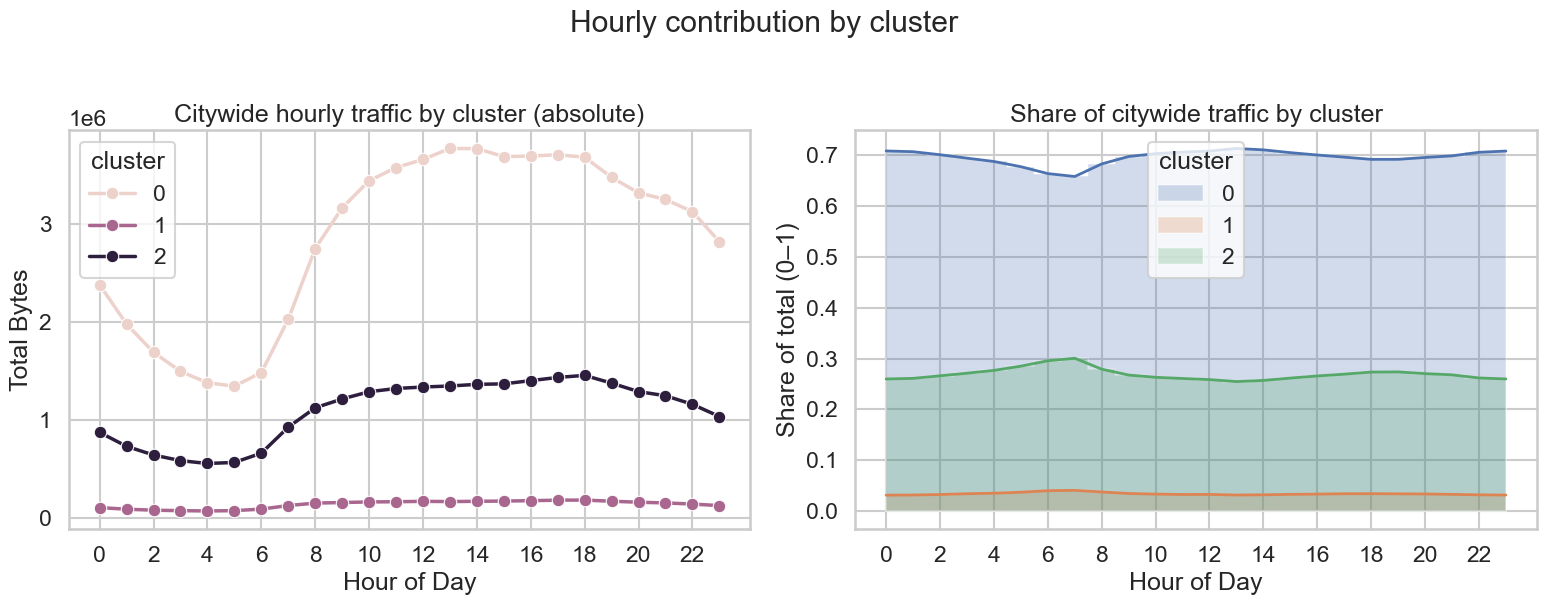

Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\figures\hourly_contribution_by_cluster.png


In [29]:
# Absolute totals by cluster-hour
abs_hour = (hourly_by_cell.groupby(["cluster","hour"])["avg_internet_bytes"]
                         .sum()
                         .reset_index()
                         .rename(columns={"avg_internet_bytes":"total_bytes"}))

# Normalized share per hour
share_hour = (abs_hour.pivot(index="hour", columns="cluster", values="total_bytes")
                     .fillna(0.0))
share_hour = share_hour.div(share_hour.sum(axis=1), axis=0).reset_index()
share_hour = share_hour.melt(id_vars="hour", var_name="cluster", value_name="share")

fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.lineplot(data=abs_hour, x="hour", y="total_bytes", hue="cluster",
             marker="o", linewidth=2.5, ax=axes[0])
axes[0].set_title("Citywide hourly traffic by cluster (absolute)")
axes[0].set_xlabel("Hour of Day"); axes[0].set_ylabel("Total Bytes"); axes[0].set_xticks(range(0,24,2))

for clu, dfc in share_hour.groupby("cluster"):
    axes[1].fill_between(dfc["hour"], 0, dfc["share"], alpha=0.25, step="mid", label=str(clu))
    axes[1].plot(dfc["hour"], dfc["share"], linewidth=2)
axes[1].set_title("Share of citywide traffic by cluster")
axes[1].set_xlabel("Hour of Day"); axes[1].set_ylabel("Share of total (0‚Äì1)")
axes[1].set_xticks(range(0,24,2)); axes[1].legend(title="cluster")

fig.suptitle("Hourly contribution by cluster", y=1.02)
fig.tight_layout()
out = FIG / "hourly_contribution_by_cluster.png"
fig.savefig(out, dpi=200); plt.show()
print("Saved:", out)


In [27]:
# Edit names if you want different wording/emojis
story_names = {
    0: "üè¢ Business / Commercial Hubs",
    1: "üè† Residential Evening Areas",
    2: "üõçÔ∏è Leisure & Mixed-use Districts",
}

clusters_by_cell["cluster_name"] = clusters_by_cell["cluster"].map(story_names)

# Save lookup + labeled cells
(clusters_by_cell[["cluster"]].drop_duplicates()
 .assign(cluster_name=lambda d: d["cluster"].map(story_names))
 .sort_values("cluster")
 .to_csv(ART / "cluster_names.csv", index=False))

clusters_by_cell.to_csv(ART / "clusters_with_names.csv", index=False)
print("Saved:", ART / "cluster_names.csv", "and", ART / "clusters_with_names.csv")


Saved: c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\cluster_names.csv and c:\Users\tempadmin.DESKTOP-C50JUBO\Desktop\DS Roadmap\CDR Mobility & Traffic Analytics Project\artifacts\clusters_with_names.csv
